In [1]:
import pandas
import datetime
import numpy
import scipy.optimize
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time
import bs4
import urllib
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
%matplotlib inline
from matplotlib import rcParams

In [2]:
# setup some cutoff values we'll use in the analysis
velCutoffUpper = 2000.
velCutoffLower = 0.
numPointsCutoffMLTMLAT = 250

In [3]:
velGmagDF = pandas.read_csv("../data/processed-vels-geomag.txt", sep=' ',\
                            parse_dates=["date", "dst_date"], infer_datetime_format=True)
velGmagDF = velGmagDF.drop('Unnamed: 0', axis=1)
# Filter out some values where number of datapoints are pretty low.
countDF = velGmagDF.groupby([ "normMLT", "MLAT" ]).size().reset_index()
countDF.columns = [ "normMLT", "MLAT", "count" ]
# Choose only columns which have atleast 100 points
countDF = countDF[ countDF["count"] >= numPointsCutoffMLTMLAT ].reset_index(drop=True)
# Merge with velsDataDF to filter out unwanted values
velGmagDF = pandas.merge( velGmagDF, countDF,\
                          on=["normMLT", "MLAT"], how='inner' )
velGmagDF.head()

,normMLT,MLAT,vSaps,azim,vMagnErr,azimErr,dtStr,tmStr,date,hour,dst_date,dst_index,dst_bin,AE,AL,AO,AU,minute,count
0,-4,60.5,634.32,-10.10,7.19,21.54,20130316,500,2013-03-16 05:00:00,5,2013-03-16 05:00:00,-19,"(-25, -10]",731,-575,-210,156,0,2677
1,-4,60.5,609.64,-10.92,3.58,9.73,20130316,502,2013-03-16 05:02:00,5,2013-03-16 05:00:00,-19,"(-25, -10]",651,-524,-199,127,2,2677
2,-4,60.5,613.71,-12.20,4.15,8.27,20130316,504,2013-03-16 05:04:00,5,2013-03-16 05:00:00,-19,"(-25, -10]",586,-470,-177,116,4,2677
3,-4,60.5,778.50,-16.19,3.80,4.90,20130316,506,2013-03-16 05:06:00,5,2013-03-16 05:00:00,-19,"(-25, -10]",562,-418,-137,144,6,2677
4,-4,60.5,578.11,-15.40,7.43,12.92,20130316,508,2013-03-16 05:08:00,5,2013-03-16 05:00:00,-19,"(-25, -10]",569,-450,-166,119,8,2677


In [4]:
# Get season data
def get_season(row):
        currMonth = row["date"].month
        if ( (currMonth >= 11) or (currMonth <= 2) ):
            return -1#"winter"
        elif ( (currMonth >= 5) and (currMonth <= 8) ):
            return 1#"summer"
        else:
            return 0#"equinox"
#         if row[timeColName] < 10:
#             currTimeStr = "000" + str( int( row[timeColName] ) )
#         elif row[timeColName] < 100:
#             currTimeStr = "00" + str( int( row[timeColName] ) )
#         elif row[timeColName] < 1000:
#             currTimeStr = "0" + str( int( row[timeColName] ) )
#         else:
#             currTimeStr = str( int( row[timeColName] ) )
#         return datetime.datetime.strptime( currDateStr\
#                         + ":" + currTimeStr, "%Y%m%d:%H%M" )
velGmagDF["season"] = velGmagDF.apply( get_season, axis=1 )
print velGmagDF.head()

   normMLT  MLAT   vSaps   azim  vMagnErr  azimErr     dtStr  tmStr  \
0       -4  60.5  634.32 -10.10      7.19    21.54  20130316    500   
1       -4  60.5  609.64 -10.92      3.58     9.73  20130316    502   
2       -4  60.5  613.71 -12.20      4.15     8.27  20130316    504   
3       -4  60.5  778.50 -16.19      3.80     4.90  20130316    506   
4       -4  60.5  578.11 -15.40      7.43    12.92  20130316    508   

                 date  hour            dst_date  dst_index     dst_bin   AE  \
0 2013-03-16 05:00:00     5 2013-03-16 05:00:00        -19  (-25, -10]  731   
1 2013-03-16 05:02:00     5 2013-03-16 05:00:00        -19  (-25, -10]  651   
2 2013-03-16 05:04:00     5 2013-03-16 05:00:00        -19  (-25, -10]  586   
3 2013-03-16 05:06:00     5 2013-03-16 05:00:00        -19  (-25, -10]  562   
4 2013-03-16 05:08:00     5 2013-03-16 05:00:00        -19  (-25, -10]  569   

    AL   AO   AU  minute  count  season  
0 -575 -210  156       0   2677       0  
1 -524 -199  1

In [5]:
seasonDF = velGmagDF.groupby( ["season", "dst_bin", "normMLT", "MLAT"] ).mean().reset_index()
summerDF = seasonDF[ seasonDF["season"] == 1 ].reset_index(drop=True)
winterDF = seasonDF[ seasonDF["season"] == -1 ].reset_index(drop=True)
equinoxDF = seasonDF[ seasonDF["season"] == 0 ].reset_index(drop=True)
# End points using azimuths
summerDF["plot_MLATEnd"] = numpy.round( (summerDF["vSaps"]/1000.) *\
                                numpy.cos( numpy.deg2rad(-90-1*summerDF["azim"]) ) +\
                                summerDF["MLAT"], 2)
summerDF["plot_normMLTEnd"] = numpy.round( (summerDF["vSaps"]/1000.) *\
                                numpy.sin( numpy.deg2rad(-90-1*summerDF["azim"]) ) +\
                                summerDF["normMLT"], 2)
winterDF["plot_MLATEnd"] = numpy.round( (winterDF["vSaps"]/1000.) *\
                                numpy.cos( numpy.deg2rad(-90-1*winterDF["azim"]) ) +\
                                winterDF["MLAT"], 2)
winterDF["plot_normMLTEnd"] = numpy.round( (winterDF["vSaps"]/1000.) *\
                                numpy.sin( numpy.deg2rad(-90-1*winterDF["azim"]) ) +\
                                winterDF["normMLT"], 2)
equinoxDF["plot_MLATEnd"] = numpy.round( (equinoxDF["vSaps"]/1000.) *\
                                numpy.cos( numpy.deg2rad(-90-1*equinoxDF["azim"]) ) +\
                                equinoxDF["MLAT"], 2)
equinoxDF["plot_normMLTEnd"] = numpy.round( (equinoxDF["vSaps"]/1000.) *\
                                numpy.sin( numpy.deg2rad(-90-1*equinoxDF["azim"]) ) +\
                                equinoxDF["normMLT"], 2)

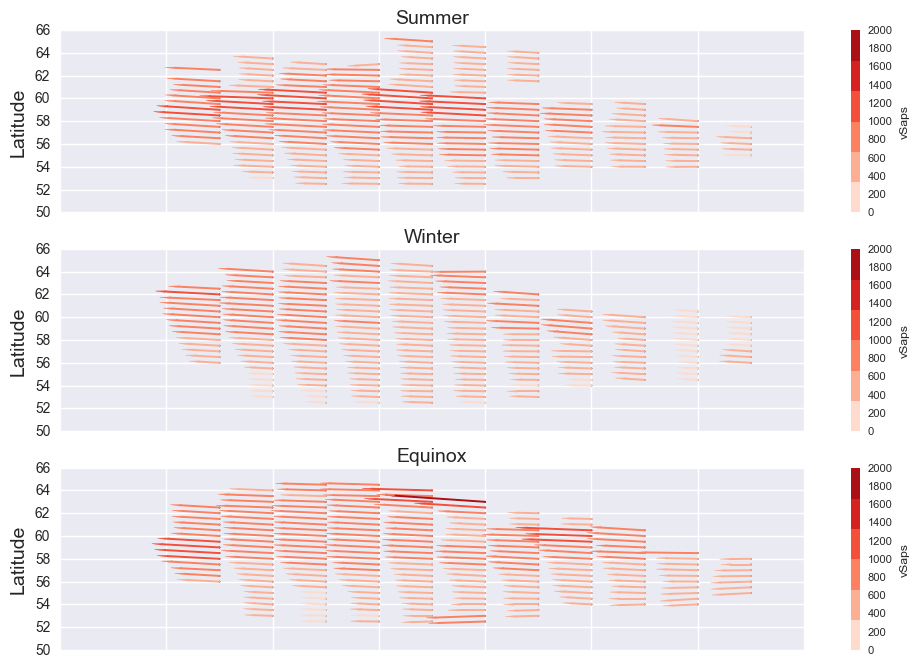

In [6]:
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(3,1,1)
ax2 = f.add_subplot(3,1,2)
ax3 = f.add_subplot(3,1,3)
# Now setup a velocity scale
velScaleMin = 0.
# round off max velocity to the next hundred
velScaleMax = 2000.
# Select a dst_bin
dstBinSelected = "(-75, -50]"
# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Reds"))

summerDFBinSlctdDF = summerDF[ summerDF["dst_bin"] == dstBinSelected ]     
summerDFBinSlctdDF.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=1., cmap=seaMap, vmin=velScaleMin, vmax=velScaleMax, ax=ax1)
ax1.set_xlabel("", fontsize=14)
ax1.set_ylabel("Latitude", fontsize=14)
ax1.set_title( "Summer", fontsize=14 )
ax1.set_xlim([-10,4])
ax1.set_ylim([50,66])


plotMLTends = summerDFBinSlctdDF['plot_normMLTEnd'].tolist()
plotMLATends = summerDFBinSlctdDF['plot_MLATEnd'].tolist()
plotMLTbegins = summerDFBinSlctdDF['normMLT'].tolist()
plotMLATbegins = summerDFBinSlctdDF['MLAT'].tolist()
plotVelMagns = summerDFBinSlctdDF['vSaps'].tolist()
# Normalize velocities according to colorbar
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMLTend, currMLATend, currMLTbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotMLATends, plotMLTbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        ax1.plot( [currMLTbgn, currMLTend], [ currMLATbgn, currMLATend ], color=currCol )        
        ax1.arrow( currMLTbgn, currMLATbgn, currMLTend-currMLTbgn, currMLATend-currMLATbgn,\
                 head_width=0.15, head_length=0.2, fc=currCol, ec=currCol)
        
        
winterDFBinSlctdDF = winterDF[ winterDF["dst_bin"] == dstBinSelected ]     
winterDFBinSlctdDF.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=1., cmap=seaMap, vmin=velScaleMin, vmax=velScaleMax, ax=ax2)
ax2.set_xlabel("", fontsize=14)
ax2.set_ylabel("Latitude", fontsize=14)
ax2.set_title( "Winter", fontsize=14 )
ax2.set_xlim([-10,4])
ax2.set_ylim([50,66])


plotMLTends = winterDFBinSlctdDF['plot_normMLTEnd'].tolist()
plotMLATends = winterDFBinSlctdDF['plot_MLATEnd'].tolist()
plotMLTbegins = winterDFBinSlctdDF['normMLT'].tolist()
plotMLATbegins = winterDFBinSlctdDF['MLAT'].tolist()
plotVelMagns = winterDFBinSlctdDF['vSaps'].tolist()
# Normalize velocities according to colorbar
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMLTend, currMLATend, currMLTbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotMLATends, plotMLTbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        ax2.plot( [currMLTbgn, currMLTend], [ currMLATbgn, currMLATend ], color=currCol )        
        ax2.arrow( currMLTbgn, currMLATbgn, currMLTend-currMLTbgn, currMLATend-currMLATbgn,\
                 head_width=0.15, head_length=0.2, fc=currCol, ec=currCol)      
        
        
        
equinoxDFBinSlctdDF = equinoxDF[ equinoxDF["dst_bin"] == dstBinSelected ]     
equinoxDFBinSlctdDF.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=1., cmap=seaMap, vmin=velScaleMin, vmax=velScaleMax, ax=ax3)
ax3.set_xlabel("", fontsize=14)
ax3.set_ylabel("Latitude", fontsize=14)
ax3.set_title( "Equinox", fontsize=14 )
ax3.set_xlim([-10,4])
ax3.set_ylim([50,66])

plotMLTends = equinoxDFBinSlctdDF['plot_normMLTEnd'].tolist()
plotMLATends = equinoxDFBinSlctdDF['plot_MLATEnd'].tolist()
plotMLTbegins = equinoxDFBinSlctdDF['normMLT'].tolist()
plotMLATbegins = equinoxDFBinSlctdDF['MLAT'].tolist()
plotVelMagns = equinoxDFBinSlctdDF['vSaps'].tolist()
# Normalize velocities according to colorbar
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMLTend, currMLATend, currMLTbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotMLATends, plotMLTbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        ax3.plot( [currMLTbgn, currMLTend], [ currMLATbgn, currMLATend ], color=currCol )        
        ax3.arrow( currMLTbgn, currMLATbgn, currMLTend-currMLTbgn, currMLATend-currMLATbgn,\
                 head_width=0.15, head_length=0.2, fc=currCol, ec=currCol)

plt.savefig("../figs/season"+ dstBinSelected +".pdf",bbox_inches='tight')        

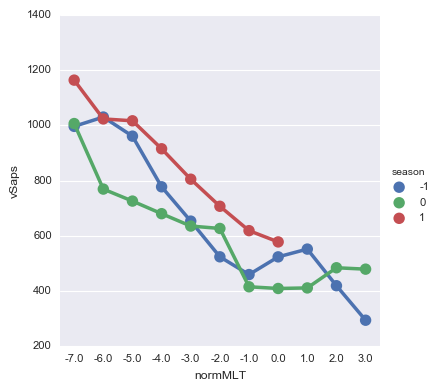

In [7]:
seasonMLTGrpDF = velGmagDF[ velGmagDF["dst_bin"] == "(-150, -75]" ].groupby( ["season", "normMLT"] ).median().reset_index()
sns.factorplot(x="normMLT", y="vSaps", hue="season", data=seasonMLTGrpDF)

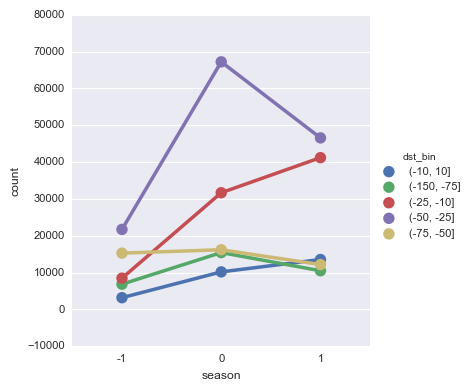

In [8]:
seasonCountDF = velGmagDF.groupby( ["season", "dst_bin"] ).size().reset_index()
seasonCountDF.columns = [ "season", "dst_bin", "count" ]
sns.factorplot(x="season", y="count", hue="dst_bin", data=seasonCountDF)